In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium
import numpy as np


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

In [8]:
df = pd.read_csv('data/df_mile.csv')
df.head()

,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time,mile_num,grade_section
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,0,0:00:00,0.000000,0,1.0,1.0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,0.000400,1.440858,0.0,0.0,0.000400,NaN,1,0:00:01,2.113258,1,1.0,1.0
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001188,0.001189,4.277103,0.0,0.0,0.001590,NaN,2,0:00:02,6.273084,1,1.0,1.0
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001180,0.001182,4.249086,0.0,0.0,0.002771,NaN,3,0:00:03,6.231993,1,1.0,1.0
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,0.002062,7.422258,0.2,0.2,0.004833,0.04,4,0:00:04,10.885979,1,1.0,1.0


In [30]:
def section_distance(df,unit):
    return df['cum_distance']//unit +1

In [87]:
unit1 = .0025
print(unit1*5280, "feet interval")
df['grade_section_exp'] = df.apply(section_distance,unit=unit1, axis=1)

def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

junder,jover = find_neighbours(unit1,df,'cum_distance')
df[junder:jover+1]

13.200000000000001 feet interval


,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time,mile_num,grade_section,grade_section_exp
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001188,0.001189,4.277103,0.0,0.0,0.001590,NaN,2,0:00:02,6.273084,1,1.0,1.0,1.0
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001180,0.001182,4.249086,0.0,0.0,0.002771,NaN,3,0:00:03,6.231993,1,1.0,1.0,2.0


In [88]:
def grade_marker_loc(df):
    grade_markers = []
    for i in range(1,len(df['grade_section_exp'].unique())):
        junder,jover  = find_neighbours(i*unit1, df, 'cum_distance')
        grade_markers.append(jover)
    return grade_markers


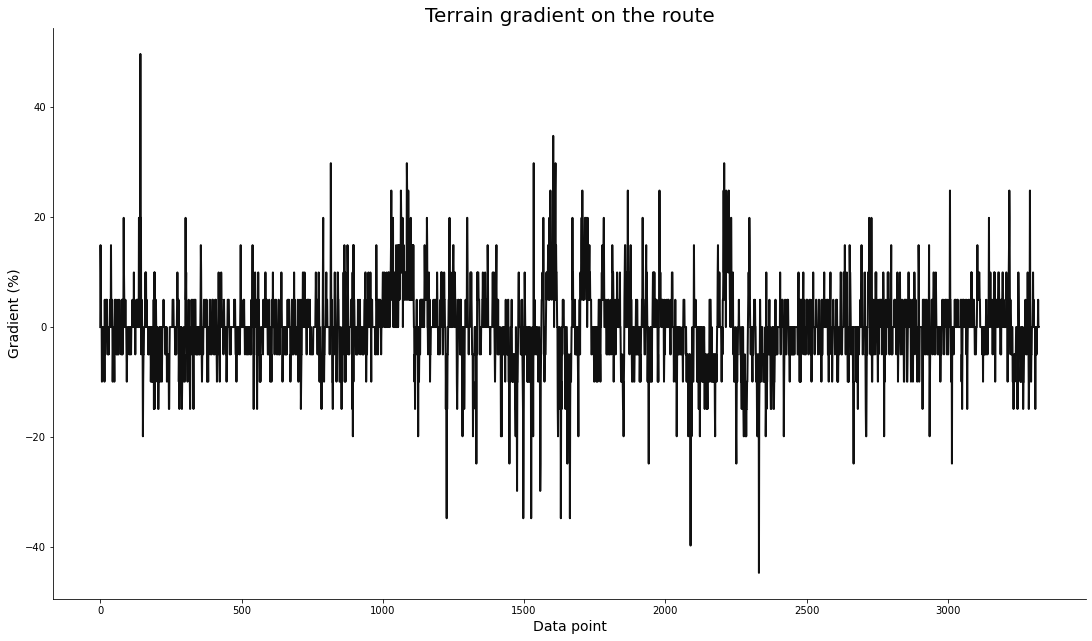

In [95]:
prev = df['elevation'][0]
conversion_factor = 0.62137119
gradient =[]
grade_markers = grade_marker_loc(df)
for i in grade_markers:
    el_diff = df['elevation'][i] - prev
    unit_gradient = el_diff/(unit1/conversion_factor*1000)*100
    gradient.append(np.round(unit_gradient,2))
    prev = df['elevation'][i]

plt.figure(figsize=(18.5, 10.5))
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradient)), gradient, lw=2, color='#101010');

In [96]:
prev = df['second'][0]
conversion_factor = 0.62137119
grade_section_speed =[]
grade_pace =[]
mile_marker = []
grade_markers = grade_marker_loc(df)
for i in grade_markers:
    time_diff = df['second'][i] - prev+1
    unit_speed = unit1/(time_diff/60/60)
    unit_pace = str(datetime.timedelta(seconds=60/unit_speed*60))
    grade_section_speed.append(np.round(unit_speed,2))
    grade_pace.append(unit_pace)
    mile_marker.append(df['mile_num'][i])
    prev = df['second'][i]
    

In [105]:
d={'mile_number':mile_marker,'speed_mph':grade_section_speed,'pace':grade_pace,'gradient':gradient}
speed_grade = pd.DataFrame(data = d)
speed_grade.describe()

,mile_number,speed_mph,gradient
count,3322.00000,3322.000000,3322.000000
mean,4.66767,4.134943,-0.137646
std,2.40352,0.880283,7.184533
min,1.00000,0.690000,-44.740000
25%,3.00000,3.000000,-4.970000
50%,5.00000,4.500000,0.000000
75%,7.00000,4.500000,4.970000
max,9.00000,9.000000,49.710000


In [98]:
import altair as alt

selection = alt.selection_multi(fields=['mile_number'])


scatter = alt.Chart(speed_grade).mark_point(size=50).encode(
    alt.X("gradient"),
    alt.Y("speed_mph"),
    alt.Color("mile_number",
                legend = alt.Legend(
                    title = "Mile Number",
                    orient = 'left',
                    titleFontSize=15,
                    labelFontSize=13)
                ),
    opacity = alt.condition(selection, alt.value(1),alt.value(0))
).properties(
    height=350, width=500
).configure_axis(
    titleFontSize=20,
    labelFontSize=15
).add_selection(
    selection
)

scatter


alt.Chart(...)

In [104]:
source = speed_grade

brush = alt.selection(type='interval')

points = alt.Chart(source).mark_point().encode(
    x='gradient:N',
    y='speed_mph:Q',
    color=alt.condition(brush, 'mile_number:N', alt.value('lightgray'))
).properties(
    height=350, width=800
).add_selection(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='mile_number:N',
    color='mile_number:N',
    x='count(mile_number):Q'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

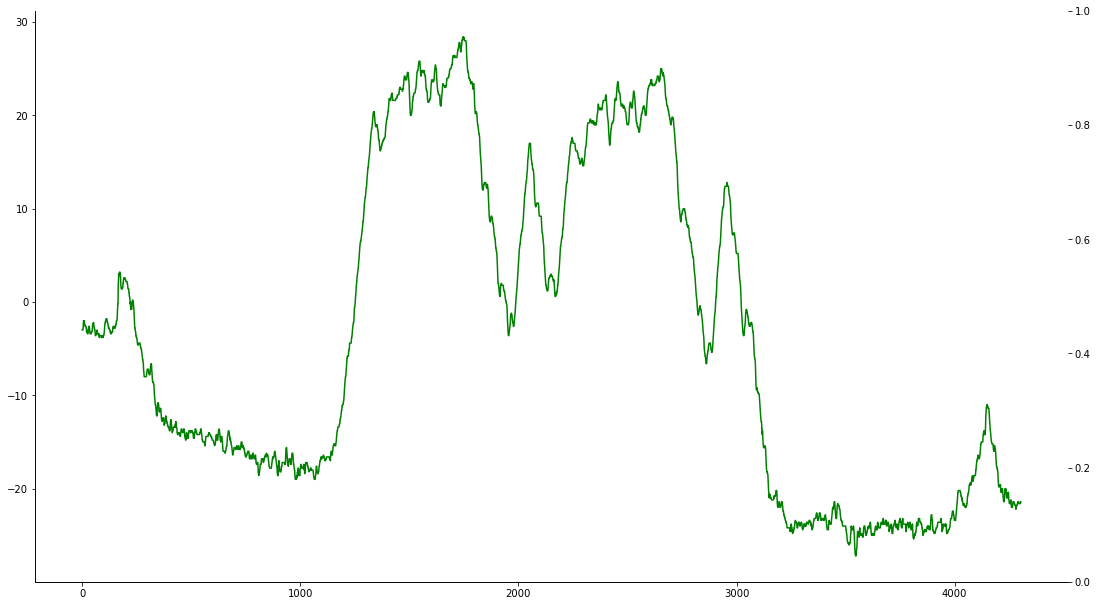

In [20]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index,df['elevation'], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')